# **Import libraries**

In [1]:
library(ggcorrplot)
library(ggplot2)
library(tidyverse)
library(lubridate)
library(dplyr)
library(plotly)
library(reshape2)
library(viridis)
library(hrbrthemes)
library(scales)
library(plyr)
library(pivottabler)

options(warn=-1)

Loading required package: ggplot2

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout


The following object is masked from ‘package:httr’:

    config



Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Loading required package: viridisLite

NOTE: Either Arial Nar

# **Datasets**

In [2]:
origin_df = read.csv('../input/dataco-smart-supply-chain-for-big-data-analysis/DataCoSupplyChainDataset.csv')
head(origin_df, 3) ; print(paste('shape:',nrow(origin_df),'x',ncol(origin_df)))

,Type,Days.for.shipping..real.,Days.for.shipment..scheduled.,Benefit.per.order,Sales.per.customer,Delivery.Status,Late_delivery_risk,Category.Id,Category.Name,Customer.City,⋯,Order.Zipcode,Product.Card.Id,Product.Category.Id,Product.Description,Product.Image,Product.Name,Product.Price,Product.Status,shipping.date..DateOrders.,Shipping.Mode
,<chr>,<int>,<int>,<dbl>,<dbl>,<chr>,<int>,<int>,<chr>,<chr>,⋯,<int>,<int>,<int>,<lgl>,<chr>,<chr>,<dbl>,<int>,<chr>,<chr>
1,DEBIT,3,4,91.25,314.64,Advance shipping,0,73,Sporting Goods,Caguas,⋯,NA,1360,73,NA,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
2,TRANSFER,5,4,-249.09,311.36,Late delivery,1,73,Sporting Goods,Caguas,⋯,NA,1360,73,NA,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
3,CASH,4,4,-247.78,309.72,Shipping on time,0,73,Sporting Goods,San Jose,⋯,NA,1360,73,NA,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class


[1] "shape: 180519 x 53"


## Find NAs

In [3]:
# colSums(is.na(origin_df))

# **Feature selection**

## correlation matrix between numeric features

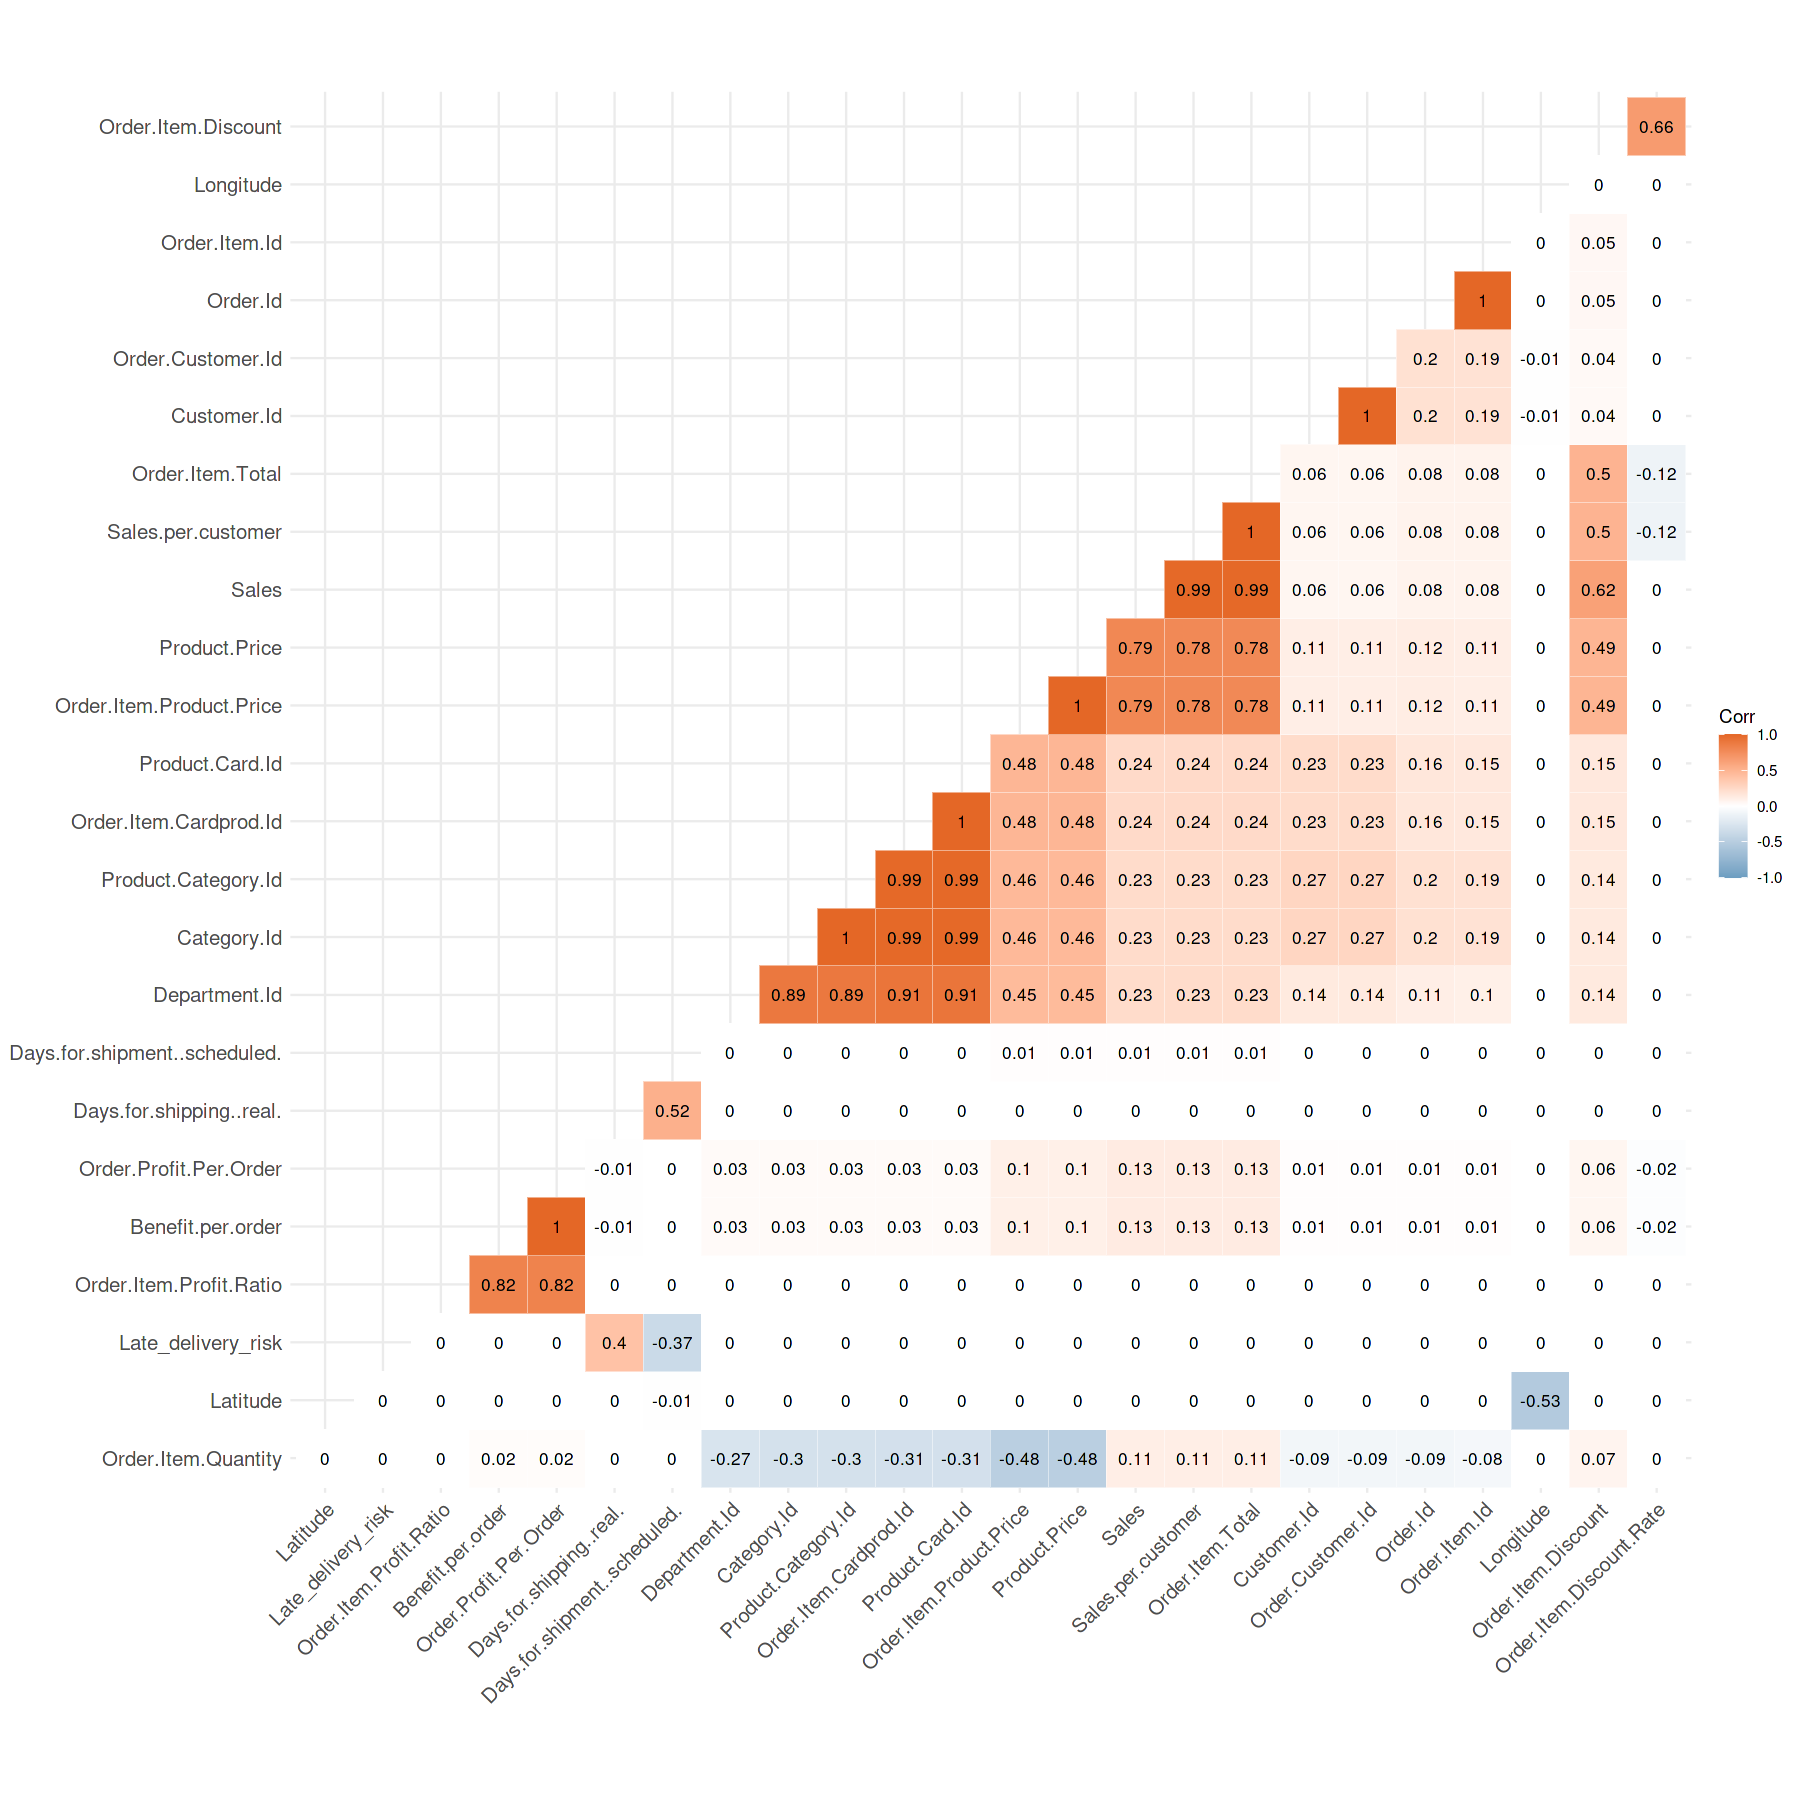

In [4]:
num_features_corrplot = function(x){
    num_idx=c()
    for (i in seq(1:ncol(x))){
        if (class(x[,i]) == 'integer'| class(x[,i]) == 'numeric'){
            num_idx = c(num_idx, i)}}
    num_idx = num_idx[-c(8, 24, 28)]  # delete Zipcodes, Product.Status cause they don't show any correlations
    
    options(repr.plot.width = 15, repr.plot.height = 15)

    corr = cor(x[num_idx])
    ggcorrplot(corr, type='lower', outline.color='white', 
               lab=T, lab_size=3.5, hc.order=T, colors = c("#6D9EC1", "white", "#E46726"))}

num_features_corrplot(origin_df)

## Similar features
- **[Benefit.per.order]**, [Order.Profit.Per.Ratio], [Order.Item.Profit.Ratio]
- **[Sales.per.customer]**, [Order.Item.Total], [Sales], [Product.Price], [Order.Item.Product.Price]
- **[Category.Id]**, [Department.Id], [Product.Category.Id], [Order.Item.Cardprod.Id], [Product.Card.Id]
- **[Order.Item.Discount.Rate]**, [Order.Item.Discount]
- **[Order.Id]**, [Order.Item.Id]
- **[Order.Customer.Id]**, [Customer.Id]

## Non-numeric features

In [5]:
num_idx=c()
for (i in seq(1:ncol(origin_df))){
    if (class(origin_df[,i]) == 'integer'| class(origin_df[,i]) == 'numeric'){
        num_idx = c(num_idx, i)}}
num_idx = num_idx[-c(8, 24, 28)]
colnames(origin_df[-num_idx])

[1] "Type"                       "Delivery.Status"           
 [3] "Category.Name"              "Customer.City"             
 [5] "Customer.Country"           "Customer.Email"            
 [7] "Customer.Fname"             "Customer.Lname"            
 [9] "Customer.Password"          "Customer.Segment"          
[11] "Customer.State"             "Customer.Street"           
[13] "Customer.Zipcode"           "Department.Name"           
[15] "Market"                     "Order.City"                
[17] "Order.Country"              "order.date..DateOrders."   
[19] "Order.Region"               "Order.State"               
[21] "Order.Status"               "Order.Zipcode"             
[23] "Product.Description"        "Product.Image"             
[25] "Product.Name"               "Product.Status"            
[27] "shipping.date..DateOrders." "Shipping.Mode"

## Unnecessary features
- customers' personal information
- product details

# **Late Delivery EDAs**

In [6]:
### set related features ###

# char2date
origin_df$order.date..DateOrders. = as.Date(origin_df$order.date..DateOrders., '%m/%d/%Y')
origin_df$shipping.date..DateOrders. = as.Date(origin_df$shipping.date..DateOrders., '%m/%d/%Y')

delv = origin_df[,c(30,1:3,6,7,29,52,53)] 

# order.date : extract date features include days of the week
delv['order.year'] = year(delv$order.date..DateOrders.)
delv['order.month'] = month(delv$order.date..DateOrders.)
delv['order.day'] = day(delv$order.date..DateOrders.)
delv['order.wday'] = wday(delv$order.date..DateOrders., label=TRUE)

# combine by Order.Id
# unique value count : length(unique(delv$Order.Id)) : 65752
n_delv = distinct(delv) ; head(n_delv) ; print(paste('shape:',nrow(n_delv),'x',ncol(n_delv)))
attach(n_delv)

,Order.Id,Type,Days.for.shipping..real.,Days.for.shipment..scheduled.,Delivery.Status,Late_delivery_risk,order.date..DateOrders.,shipping.date..DateOrders.,Shipping.Mode,order.year,order.month,order.day,order.wday
,<int>,<chr>,<int>,<int>,<chr>,<int>,<date>,<date>,<chr>,<dbl>,<dbl>,<int>,<ord>
1,77202,DEBIT,3,4,Advance shipping,0,2018-01-31,2018-02-03,Standard Class,2018,1,31,Wed
2,75939,TRANSFER,5,4,Late delivery,1,2018-01-13,2018-01-18,Standard Class,2018,1,13,Sat
3,75938,CASH,4,4,Shipping on time,0,2018-01-13,2018-01-17,Standard Class,2018,1,13,Sat
4,75937,DEBIT,3,4,Advance shipping,0,2018-01-13,2018-01-16,Standard Class,2018,1,13,Sat
5,75936,PAYMENT,2,4,Advance shipping,0,2018-01-13,2018-01-15,Standard Class,2018,1,13,Sat
6,75935,TRANSFER,6,4,Shipping canceled,0,2018-01-13,2018-01-19,Standard Class,2018,1,13,Sat


[1] "shape: 65752 x 13"


In [7]:
### Customized plot fuctions ###

### order_counts_per_year ###
order_counts_per_year = function(dataframe){
    df = dataframe %>% 
         group_by(order.month, order.year) %>%
         tally()

    options(repr.plot.width = 14, repr.plot.height = 10)

    g = ggplot(df, aes(x=order.month, y=n, group=1))+
        geom_point(size=3)+
        geom_line(linetype='dashed')+
        facet_wrap(~order.year)+
        geom_text(aes(label=n), position='dodge', vjust=-1.2, size=5)+
        xlab('\nMonth') + ylab('Total Order Count\n') +
        ylim(1500, 2200)+
        ggtitle('Order Counts per Year(2015-2018)')+
        theme(text = element_text(size=20),
              plot.title = element_text(size=24, face='bold'))
    return(g)}

### delivery_status_per_year ###
delivery_status_per_year = function(dataframe){
    df = dataframe %>%
    group_by(Delivery.Status, order.month, order.year)%>%
    tally()%>%
    mutate(percent = n/sum(n))

    options(repr.plot.width = 16, repr.plot.height = 11)

    g = ggplot(df, aes(x=order.month, y=n, fill=Delivery.Status))+
        geom_bar(stat='identity')+
        facet_wrap(~order.year)+
        geom_text(data=subset(df, Delivery.Status != 'Shipping canceled'),
                  aes(label=paste0(sprintf("%1.1f", percent*100),"%")),
                      position=position_stack(vjust=0.5), colour="white", size = 3.9)+
        ggtitle('Delivery Status per year (2015-2018)')+
        scale_fill_manual(values=c('#16003B','#F73D93', '#413F42', '#7F8487')) +
        scale_x_discrete(breaks=seq(1:12))+
        xlab('\nMonth') +
        ylab('Total Order Count\n') +
        theme_light() +
        theme(text = element_text(size=20),
              plot.title = element_text(size=24, face='bold'),
              legend.justification = c('right', 'bottom'),
              legend.position=c(.98, .28),
              legend.box.background = element_rect(colour='#D0C9C0'))

    return(g)}

### delivery_status_per_wday ###
delivery_status_per_wday = function(dataframe){
    df = dataframe %>%
    group_by(Delivery.Status, order.wday, order.year)%>%
    tally()%>%
    mutate(percent = n/sum(n))
    
    options(repr.plot.width = 16, repr.plot.height = 11)
    
    g = ggplot(df, aes(x=order.wday, y=n, fill=Delivery.Status))+
        geom_bar(stat='identity')+
        facet_wrap(~order.year)+
        geom_text(data=subset(df, (Delivery.Status != 'Shipping canceled')&
                                  (order.year != 2018)),
                  aes(label=paste0(sprintf("%1.2f", percent*100),"%")),
                      position=position_stack(vjust=0.5), colour="white", size = 4)+
        ggtitle('Delivery Status per Days of Week (2015-2018)')+
        scale_fill_manual(values=c('#9FC088','#E8C07D', '#CC704B', '#614124')) +
        xlab('\nDays of Week')+
        ylab('Total Order Count\n') +
        theme_light() +
        theme(text = element_text(size=20),
              plot.title = element_text(size=24, face='bold'),
              legend.justification = c('right', 'bottom'),
              legend.position=c(.98, .28),
              legend.box.background = element_rect(colour='#D0C9C0'))
    return(g)}

### delivery_status_per_type ###
delivery_status_per_ptype = function(dataframe){
    df = dataframe %>%
         group_by(Type, Delivery.Status)%>%
         tally()%>%
         mutate(percent = n/sum(n))  
    
    options(repr.plot.width = 10, repr.plot.height = 8)

    g = ggplot(df, aes(x=Type, y=n, fill=Delivery.Status))+
        geom_bar(stat='identity')+
        geom_text(aes(label=paste0(sprintf('%1.1f', percent*100),'%')),
                      position=position_stack(vjust=0.5), colour='#203239', size=5)+
        ggtitle('Delivery Status per Payment Type')+
        scale_fill_manual(values=c('#019267','#00C897', '#FFD365', '#FDFFA9'))+
        xlab('\nPayment Type') + ylab('Total Order Count\n')+
        theme_light()+
        theme(text = element_text(size=20),
              plot.title = element_text(face='bold'))
    return(g)}

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



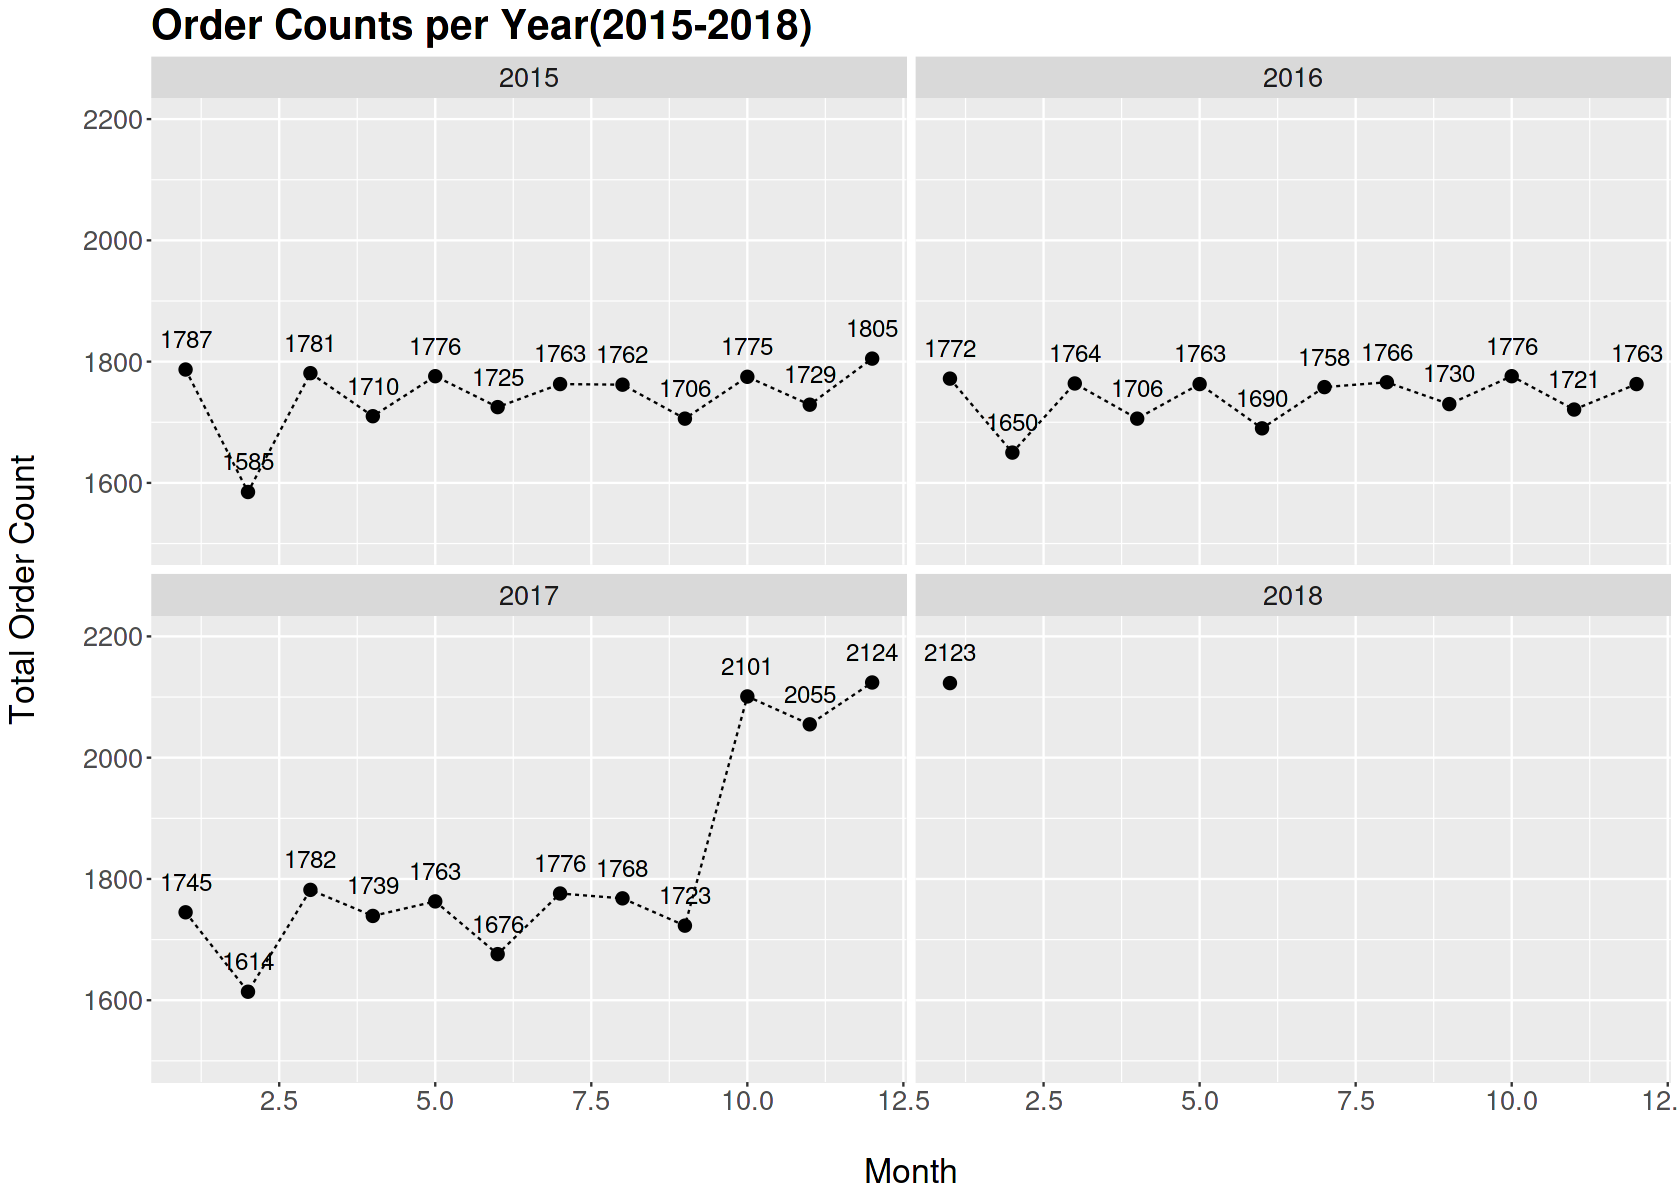

In [8]:
order_counts_per_year(n_delv)

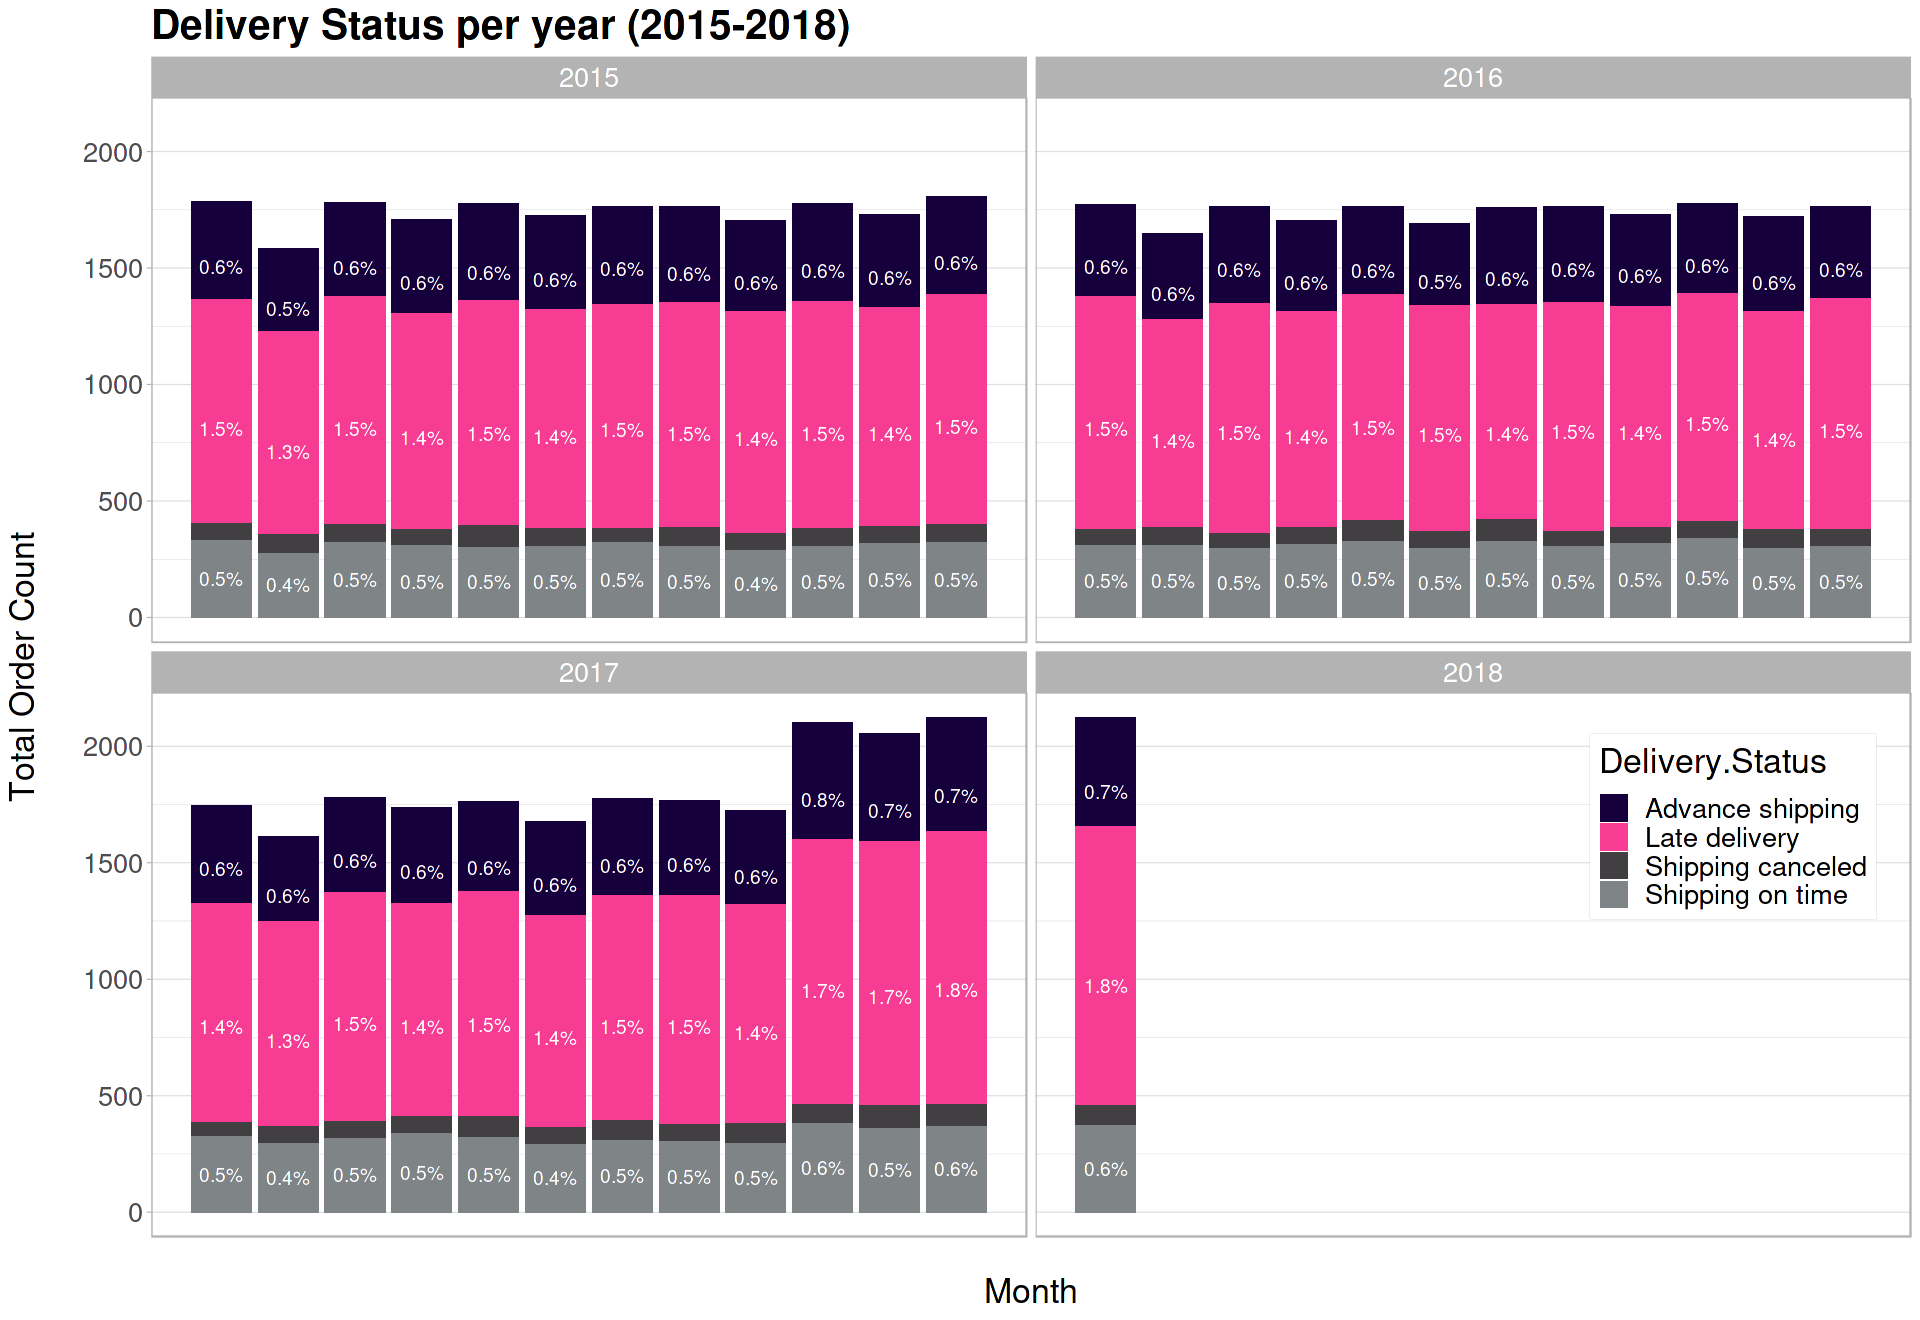

In [9]:
delivery_status_per_year(n_delv)

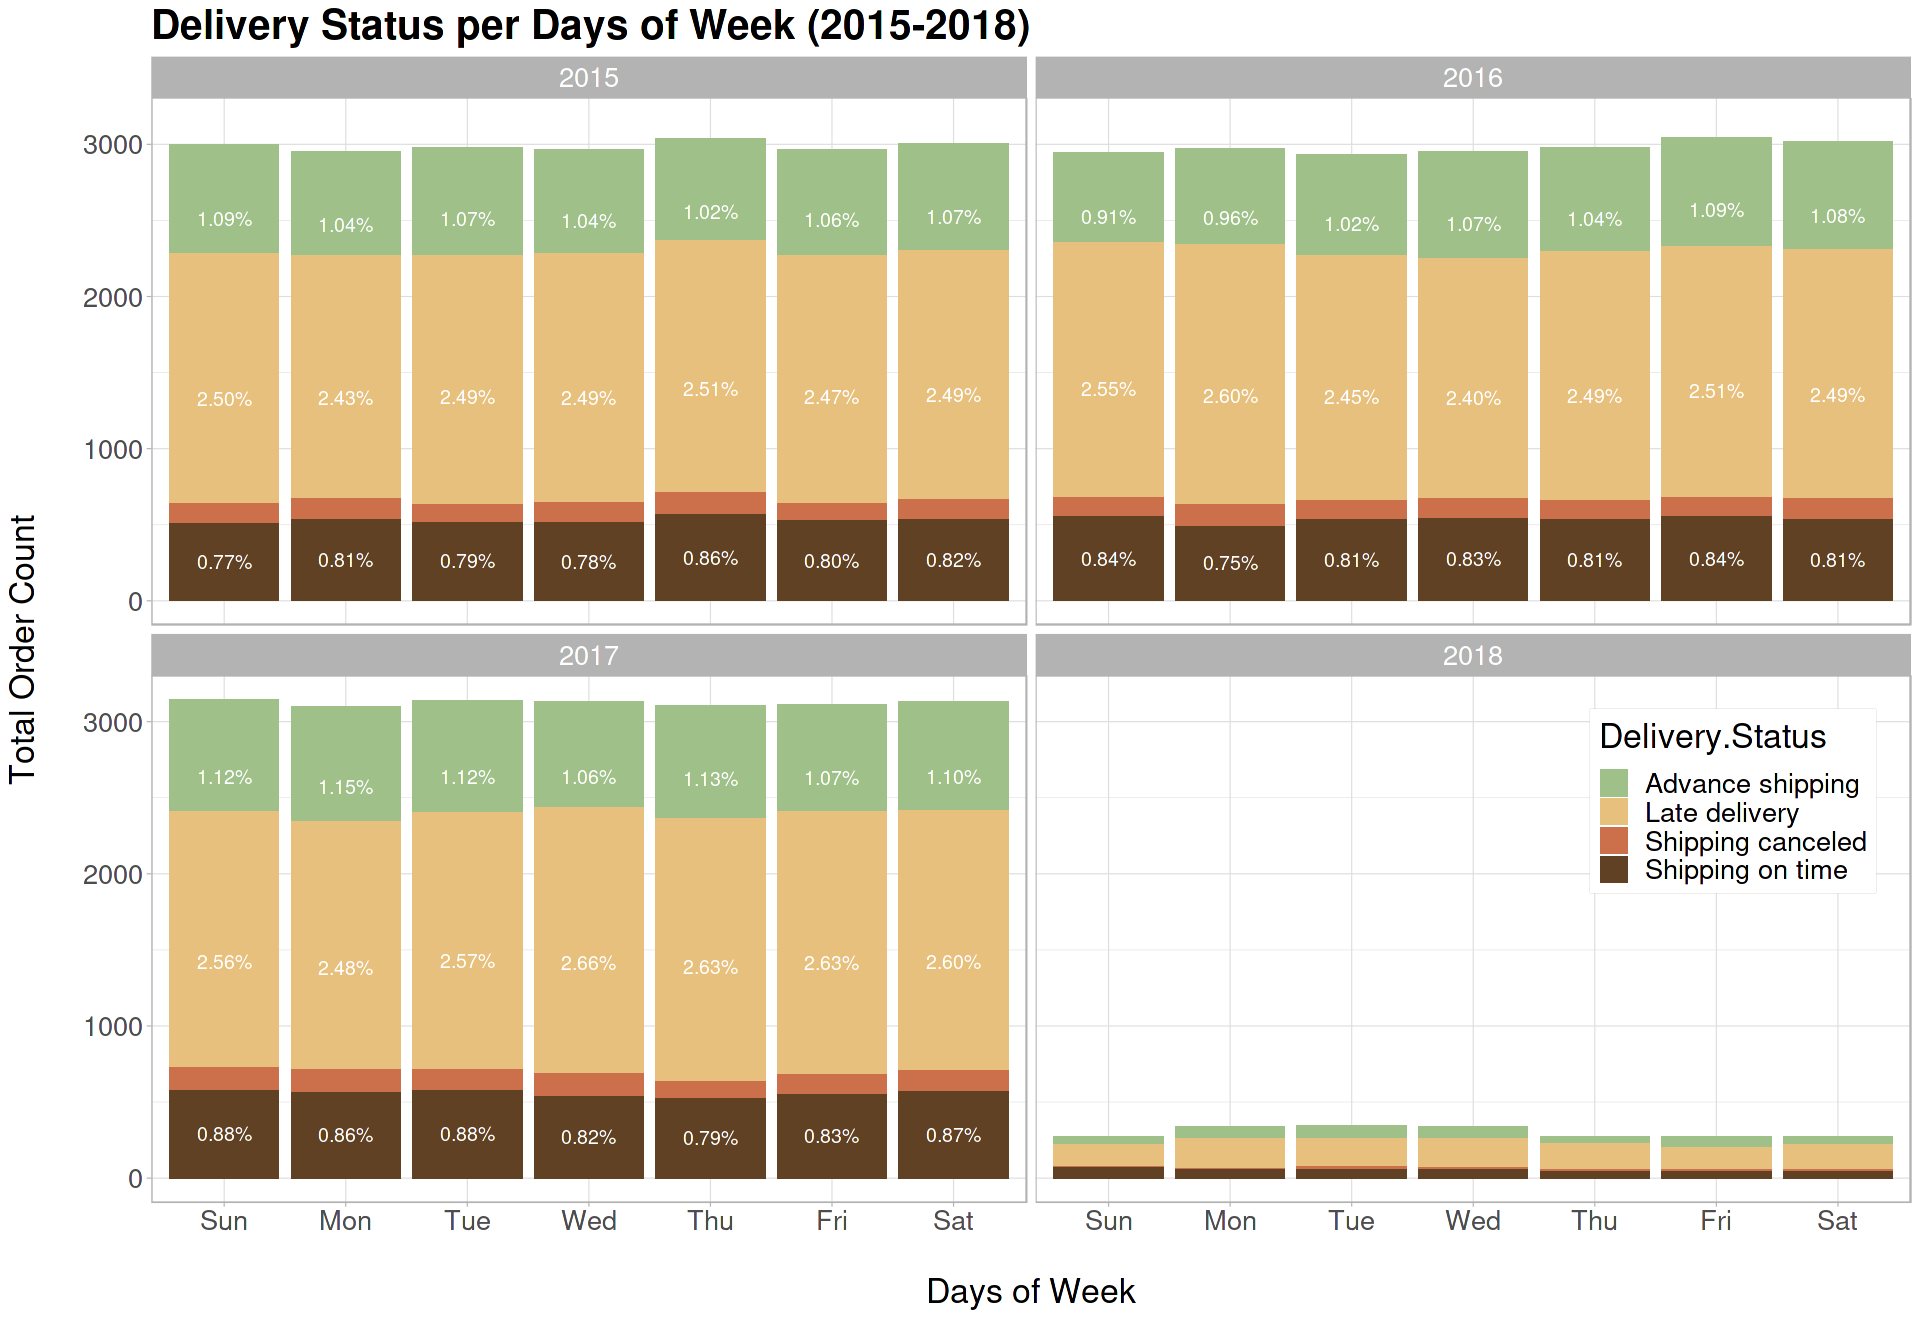

In [10]:
delivery_status_per_wday(n_delv) 

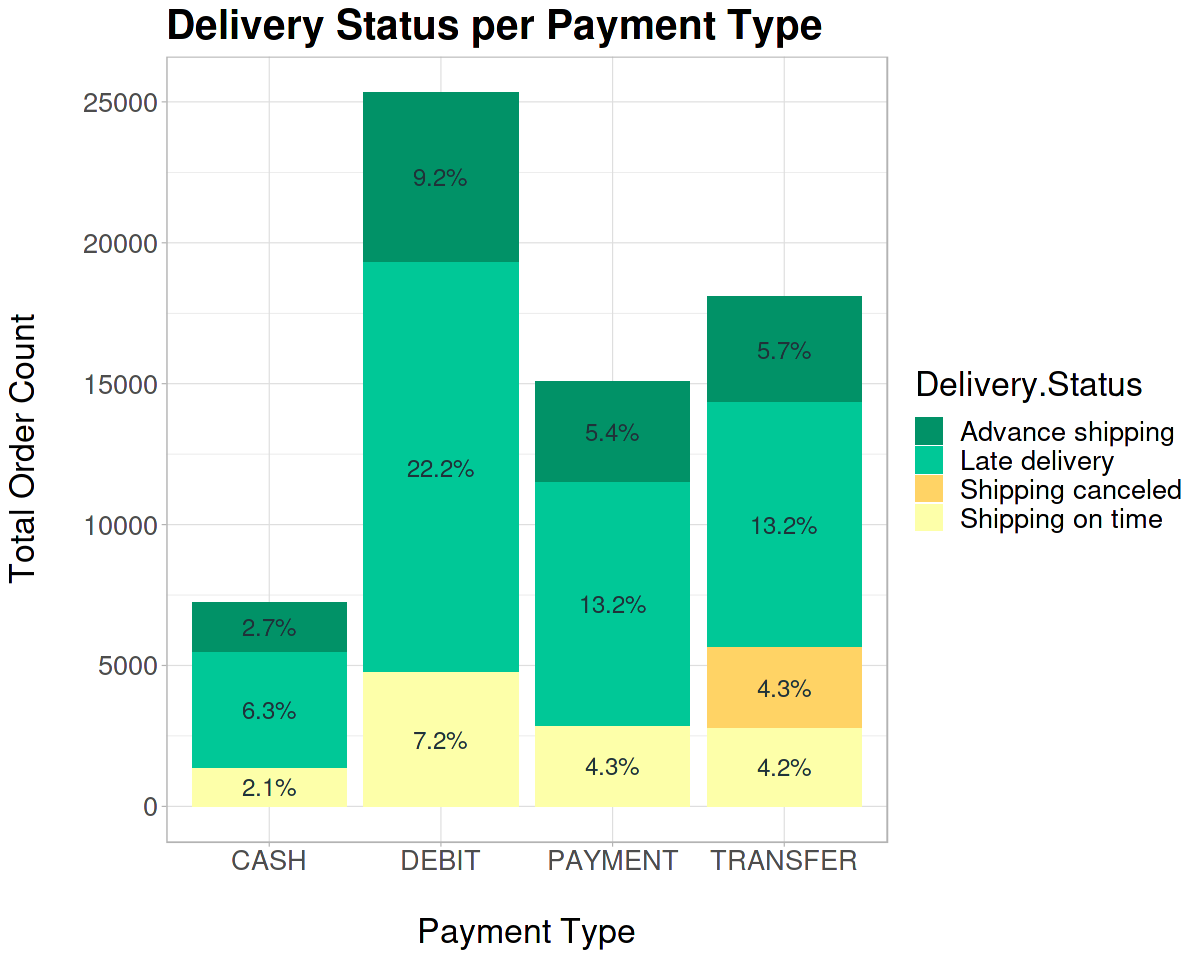

In [11]:
delivery_status_per_ptype(n_delv)